# Exploratory linear analysis for NDVI in South America

- Data from NASA/GSFC GIMMS NDVI3g version 1 1981-07-01 - 2015-12-31 1/12 x 1/12 degrees 1/24 a year.
- Original data spatial resolution as well as regridded data in order to fit ERA-INTERIM grid.
- Monthly means maps.
- Standard deviation.
- Seasonal means maps.
- Empirical orthogonal functions analysis for regridded data.

## Initial setup

In [1]:
%load_ext autoreload
%autoreload 2 

In [2]:
import warnings 

In [3]:
warnings.filterwarnings("ignore")

In [4]:
# Load packages
import sys
import glob
import calendar
import itertools

from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from dask.diagnostics import ProgressBar
from cartopy import crs as ccrs
from cartopy import feature as cfeature
from cartopy.io import shapereader
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid
from eofs.xarray import Eof
from sklearn.metrics import r2_score

import numpy as np
import xarray as xr
import pandas as pd

%matplotlib inline

In [5]:
print(">>> Version of xarray:", xr.__version__)                                

>>> Version of xarray: 0.14.0


In [6]:
# My repository.
repository = "/home/alex/Dropbox/repositories/"

# Include once my repository in the path for searching libraries.
if repository not in sys.path:
    sys.path.append(repository)
    
# Import my package.
import cdlearn

# Map borders.
loni, lonf, lati, latf = -90, -30, 20, -60

# Where figures will be put.
fig_path = "/home/alex/Dropbox/repositories/phd/images/"

In [7]:
# Folder with data.
DATA_FOLDER = "/media/alex/ALEXDATA/data_sets/GIMMS/NDVI/"

In [8]:
# First we will use cartopy's shapereader to download (and cache) states shapefile with 50 
# meters resolution from the NaturalEarth.
kw = dict(resolution="50m", category="cultural", name="admin_1_states_provinces")
states_shp = shapereader.natural_earth(**kw)
shp = shapereader.Reader(states_shp)

## Load data

In [9]:
# Including regridded.
ALL_FILES_PATHS = sorted(glob.glob(DATA_FOLDER + "*.nc4"))

FILES_PATHS_ORIGINAL = []
FILES_PATHS_REGRIDDED = []
for FILE_PATH in ALL_FILES_PATHS:

    # Excluding regridded.
    if "regridded" not in FILE_PATH:
        FILES_PATHS_ORIGINAL.append(FILE_PATH)

    # Only spatial regridded data    
    else:                    
        FILES_PATHS_REGRIDDED.append(FILE_PATH)

In [10]:
%%time

# Lazy read of global data sets.
DSo = xr.open_mfdataset(FILES_PATHS_ORIGINAL, concat_dim="time")
DSr = xr.open_mfdataset(FILES_PATHS_REGRIDDED, concat_dim="time")

# South America.
DSo = DSo.sel(lon=slice(loni, lonf), lat=slice(lati, latf))
DSr = DSr.sel(longitude=slice(loni, lonf), latitude=slice(lati, latf))

CPU times: user 1.78 s, sys: 148 ms, total: 1.93 s
Wall time: 3.8 s


In [11]:
DSo

<xarray.Dataset>
Dimensions:     (lat: 960, lon: 720, time: 828)
Coordinates:
  * lon         (lon) float64 -89.96 -89.88 -89.79 ... -30.21 -30.13 -30.04
  * lat         (lat) float64 19.96 19.88 19.79 19.71 ... -59.79 -59.88 -59.96
  * time        (time) float64 7.0 7.5 8.0 8.5 9.0 ... 10.5 11.0 11.5 12.0 12.5
Data variables:
    satellites  (time) int16 dask.array<chunksize=(12,), meta=np.ndarray>
    ndvi        (time, lat, lon) float32 dask.array<chunksize=(12, 960, 720), meta=np.ndarray>
    percentile  (time, lat, lon) int16 dask.array<chunksize=(12, 960, 720), meta=np.ndarray>
Attributes:
    FileName:              ndvi3g_geo_v1_1981_0712.nc4
    Institution:           NASA/GSFC GIMMS
    Data:                  NDVI3g version 1
    Reference:             1. Pinzon, J.E.; Tucker, C.J.                     ...
    CommentsVersion1:      version1 includes two major fixes (a and b), and t...
    Temporalrange:         1981-07-01 -> 2015-12-31
    Year:                  1981.0
    Ran

In [12]:
DSr

<xarray.Dataset>
Dimensions:    (latitude: 107, longitude: 81, time: 828)
Coordinates:
  * longitude  (longitude) float64 -90.0 -89.25 -88.5 ... -31.5 -30.75 -30.0
  * latitude   (latitude) float64 19.5 18.75 18.0 17.25 ... -58.5 -59.25 -60.0
  * time       (time) float64 7.0 7.5 8.0 8.5 9.0 ... 10.5 11.0 11.5 12.0 12.5
Data variables:
    ndvi       (time, latitude, longitude) float64 dask.array<chunksize=(12, 107, 81), meta=np.ndarray>

**DANGER ZONE:** LOAD DATA INTO MEMORY!

In [13]:
# Xarray DataArray object for NDVI.
DAo = DSo.ndvi
DAr = DSr.ndvi

In [14]:
# Load into memory.
with ProgressBar():
    DAo = DAo.compute()

[########################################] | 100% Completed |  1min 35.5s


In [15]:
# Load into memory.
with ProgressBar():
    DAr = DAr.compute()

[########################################] | 100% Completed | 16.6s


## Preprocess data

In [16]:
# Scale factor and valid range of data [-0.3, 1.0].
DAo = DAo / 1e4
DAo = DAo.where(cond=(DAo > -0.3), other=-0.3)
DAo = DAo.where(cond=(DAo < 1.0), other=1.0)

# Make time coordinate as datetime.
time_values = pd.date_range(start="1981-07-01", end="2015-12-31", periods=DAo.time.size)
DAo["time"] = time_values

In [17]:
# Scale factor and valid range of data [-0.3, 1.0].
DAr = DAr / 1e4
DAr = DAr.where(cond=(DAr > -0.3), other=-0.3)
DAr = DAr.where(cond=(DAr < 1.0), other=1.0)

# Make time coordinate as datetime.
DAr["time"] = time_values

In [18]:
# Only land pixels at ERA-INTERIM grid.
DAr = cdlearn.pixels.EraInterimGrid.add_land_mask(DAr)
DAr = DAr.where(DAr.land_mask == True)

## Monthly means maps

In [19]:
# Monthly means.
DAo_mm = DAo.groupby("time.month").mean("time")
DAr_mm = DAr.groupby("time.month").mean("time")

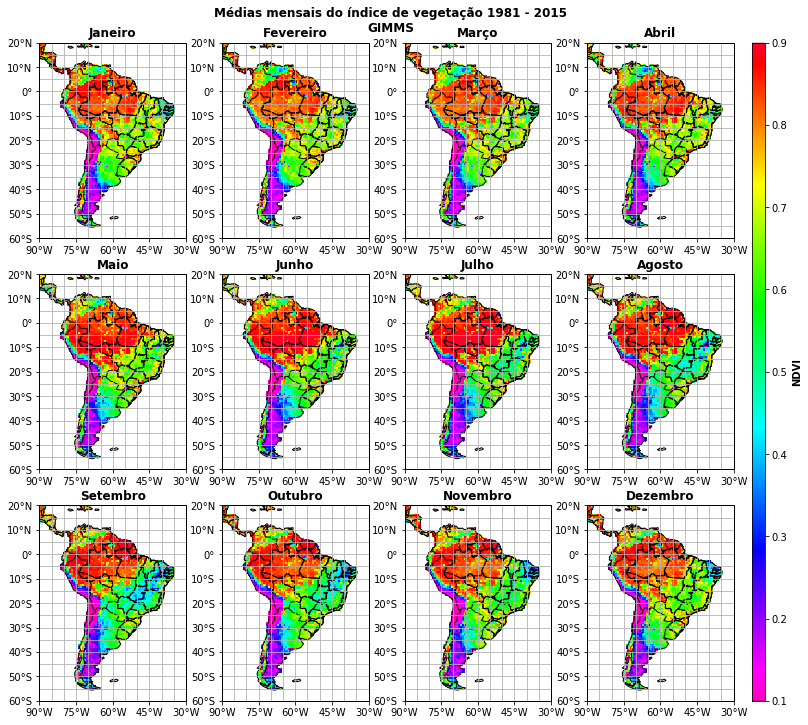

In [20]:
# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(13, 12))
axgr = AxesGrid(fig=fig, 
                rect=111, 
                axes_class=axes_class,
                nrows_ncols=(3, 4),
                axes_pad=0.5,
                cbar_location="right",
                cbar_mode="single",
                cbar_pad=0.25,
                cbar_size="3%",
                label_mode="")

# Make maps.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([loni, lonf, latf, lati], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-90, -15, 15), crs=projection)
    axis.set_yticks(np.arange(-60, 30, 10), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-90, -25, 5), ylocs=range(-60, 25, 5))        
   
    # Plot data on these maps.
    p = DAr_mm[index].where(DAr_mm.land_mask==True).plot(
        ax=axis,
        vmin=0.1,
        vmax=0.9,
        cmap=plt.cm.gist_rainbow_r,
        add_colorbar=False,
        add_labels=False)

    axis.set_title(cdlearn.auxiliary.months_labels_pt[index], weight="bold")
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(geoms=[state], 
                            crs=projection, 
                            facecolor="none", 
                            edgecolor="black")    

# Fill common colorbar.        
cb = axgr.cbar_axes[0].colorbar(p)
cb.set_label_text("NDVI", weight="bold")
cb.cbar_axis.set_ticks(np.arange(0.1, 1.0, 0.1))        
plt.suptitle("Médias mensais do índice de vegetação 1981 - 2015\nGIMMS", weight="bold")
plt.subplots_adjust(top=0.99)    

# Save figures.
plt.savefig(fig_path + "ndvi_gimms_mmeans_pt.jpg", dpi=200, bbox_inches="tight")

## Mean map 

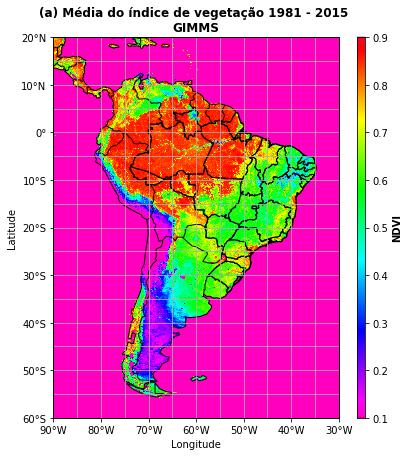

In [21]:
# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(7, 7))
axgr = AxesGrid(fig=fig, 
                rect=111, 
                axes_class=axes_class,
                nrows_ncols=(1, 1),
                axes_pad=0.02,
                cbar_location="right",
                cbar_mode="single",
                cbar_pad=0.25,
                cbar_size="3%",
                label_mode="")

# Make map.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([loni, lonf, latf, lati], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-90, -20, 10), crs=projection)
    axis.set_yticks(np.arange(-60, 30, 10), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-90, -25, 5), ylocs=range(-60, 25, 5))

    # Plot data on this map.
    p = DAo.mean("time").plot(
        ax=axis,
        vmin=0.1,
        vmax=0.9,
        cmap=plt.cm.gist_rainbow_r,
        add_colorbar=False,
        add_labels=False)
    
    # Labels.
    p.axes.set_xlabel("Longitude")
    p.axes.set_ylabel("Latitude")
    p.axes.set_title("(a) Média do índice de vegetação 1981 - 2015 \n" + \
                     "GIMMS", weight="bold")
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(geoms=[state], 
                            crs=projection, 
                            facecolor="none", 
                            edgecolor="black")

# Fill common colorbar.        
cb = axgr.cbar_axes[0].colorbar(p)
cb.set_label_text("NDVI", weight="bold")
cb.cbar_axis.set_ticks(np.arange(0.1, 1.0, 0.1))

# Save figure.
plt.savefig(fig_path + "ndvi_gimms_mean_ori_pt.jpg", dpi=200, bbox_inches="tight")

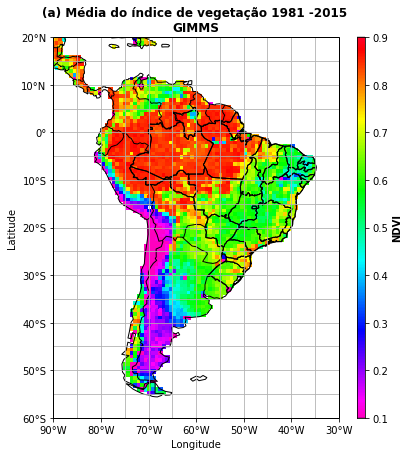

In [22]:
# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(7, 7))
axgr = AxesGrid(fig=fig, 
                rect=111, 
                axes_class=axes_class,
                nrows_ncols=(1, 1),
                axes_pad=0.02,
                cbar_location="right",
                cbar_mode="single",
                cbar_pad=0.25,
                cbar_size="3%",
                label_mode="")

# Make map.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([loni, lonf, latf, lati], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-90, -20, 10), crs=projection)
    axis.set_yticks(np.arange(-60, 30, 10), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-90, -25, 5), ylocs=range(-60, 25, 5))

    # Plot data on this map.
    p = DAr.mean("time").plot(
        ax=axis,
        vmin=0.1,
        vmax=0.9,
        cmap=plt.cm.gist_rainbow_r,
        add_colorbar=False,
        add_labels=False)
    
    # Labels.
    p.axes.set_xlabel("Longitude")
    p.axes.set_ylabel("Latitude")
    p.axes.set_title("(a) Média do índice de vegetação 1981 -2015 \n" + \
                     "GIMMS", weight="bold")
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(geoms=[state], 
                            crs=projection, 
                            facecolor="none", 
                            edgecolor="black")

# Fill common colorbar.        
cb = axgr.cbar_axes[0].colorbar(p)
cb.set_label_text("NDVI", weight="bold")
cb.cbar_axis.set_ticks(np.arange(0.1, 1.0, 0.1))

# Save figures.
plt.savefig(fig_path + "ndvi_gimms_mean_deg_pt.jpg", dpi=200, bbox_inches="tight")

## Standard deviation

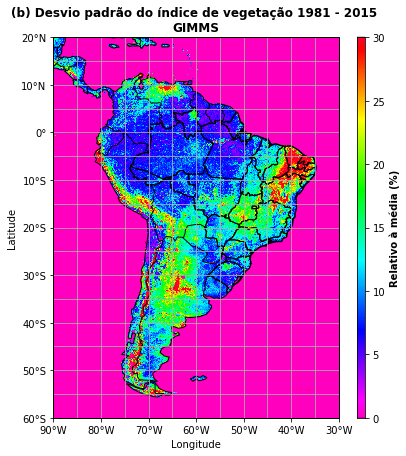

In [23]:
# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(7, 7))
axgr = AxesGrid(fig=fig, 
                rect=111, 
                axes_class=axes_class,
                nrows_ncols=(1, 1),
                axes_pad=0.02,
                cbar_location="right",
                cbar_mode="single",
                cbar_pad=0.25,
                cbar_size="3%",
                label_mode="")

# Make map.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([loni, lonf, latf, lati], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-90, -20, 10), crs=projection)
    axis.set_yticks(np.arange(-60, 30, 10), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-90, -25, 5), ylocs=range(-60, 25, 5))

    # Plot data on this map.
    p = (DAo.std("time") / DAo.mean("time") * 100).plot(
        ax=axis,
        vmin=0,
        vmax=30,
        cmap=plt.cm.gist_rainbow_r,
        add_colorbar=False,
        add_labels=False)
    
    # Labels.
    p.axes.set_xlabel("Longitude")
    p.axes.set_ylabel("Latitude")
    p.axes.set_title("(b) Desvio padrão do índice de vegetação 1981 - 2015 \n" + \
                     "GIMMS", weight="bold")
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(geoms=[state], 
                            crs=projection, 
                            facecolor="none", 
                            edgecolor="black")

# Fill common colorbar.        
cb = axgr.cbar_axes[0].colorbar(p)
cb.set_label_text("Relativo à média (%)", weight="bold")
cb.cbar_axis.set_ticks(np.arange(0, 35, 5))

# Save figure.
plt.savefig(fig_path + "ndvi_gimms_std_ori_pt.jpg", dpi=200, bbox_inches="tight")

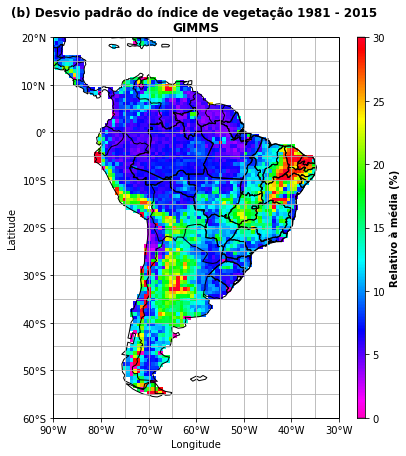

In [24]:
# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(7, 7))
axgr = AxesGrid(fig=fig, 
                rect=111, 
                axes_class=axes_class,
                nrows_ncols=(1, 1),
                axes_pad=0.02,
                cbar_location="right",
                cbar_mode="single",
                cbar_pad=0.25,
                cbar_size="3%",
                label_mode="")

# Make map.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([loni, lonf, latf, lati], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-90, -20, 10), crs=projection)
    axis.set_yticks(np.arange(-60, 30, 10), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-90, -25, 5), ylocs=range(-60, 25, 5))

    # Plot data on this map.
    p = (DAr.std("time") / DAr.mean("time") * 100).plot(
        ax=axis,
        vmin=0,
        vmax=30,
        cmap=plt.cm.gist_rainbow_r,
        add_colorbar=False,
        add_labels=False)
    
    # Labels.
    p.axes.set_xlabel("Longitude")
    p.axes.set_ylabel("Latitude")
    p.axes.set_title("(b) Desvio padrão do índice de vegetação 1981 - 2015 \n" + \
                     "GIMMS", weight="bold")
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(geoms=[state], 
                            crs=projection, 
                            facecolor="none", 
                            edgecolor="black")

# Fill common colorbar.        
cb = axgr.cbar_axes[0].colorbar(p)
cb.set_label_text("Relativo à média (%)", weight="bold")
cb.cbar_axis.set_ticks(np.arange(0, 35, 5))

# Save figure.
plt.savefig(fig_path + "ndvi_gimms_std_deg_pt.jpg", dpi=200, bbox_inches="tight")

## Seasonal means maps

In [25]:
# Seasonal means.
DAo_se = DAo.groupby("time.season").mean("time")
DAr_se = DAr.groupby("time.season").mean("time")

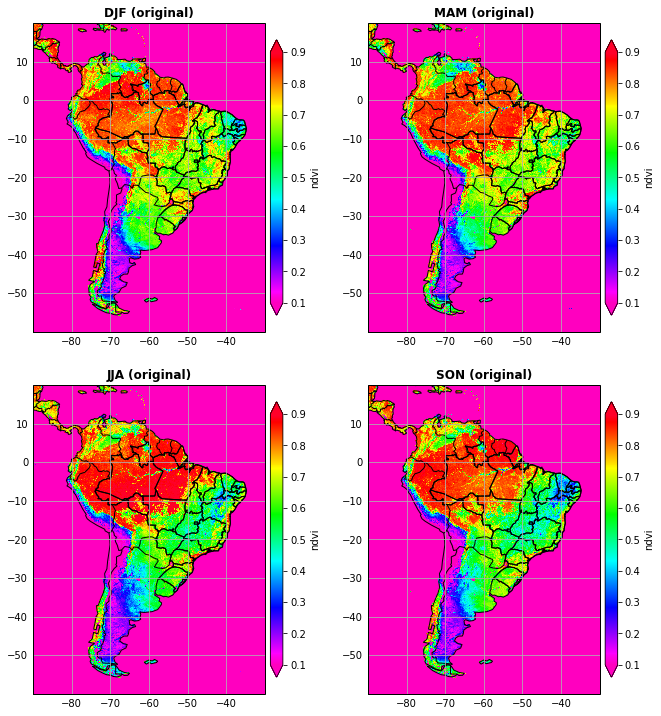

In [26]:
# Make figure.
plt.figure(figsize=(11, 13))

# Counter.
c = itertools.count(start=0, step=1)

# Seasons.
seasons=["DJF", "MAM", "JJA", "SON"]

# One map for each season.
for i in range(1, 5):

    season = seasons[next(c)]
    ax = plt.subplot(2, 2, i, projection=ccrs.PlateCarree())
    ax.set_extent([loni, lonf, latf, lati], crs=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS)
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = False
    gl.ylabels_right = False
    DAo_se.sel(season=season).plot(ax=ax, 
                                   vmin=0.1, vmax=0.9,
                                   cmap=plt.cm.gist_rainbow_r, 
                                   cbar_kwargs={"shrink": 0.80,
                                                "pad": 0.020,
                                                "extend": "both"})
    ax.set_title(season + " (original)", weight="bold")
    plt.subplots_adjust(hspace=0.05)
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        ax.add_geometries([state], ccrs.PlateCarree(), facecolor="none", edgecolor="black")

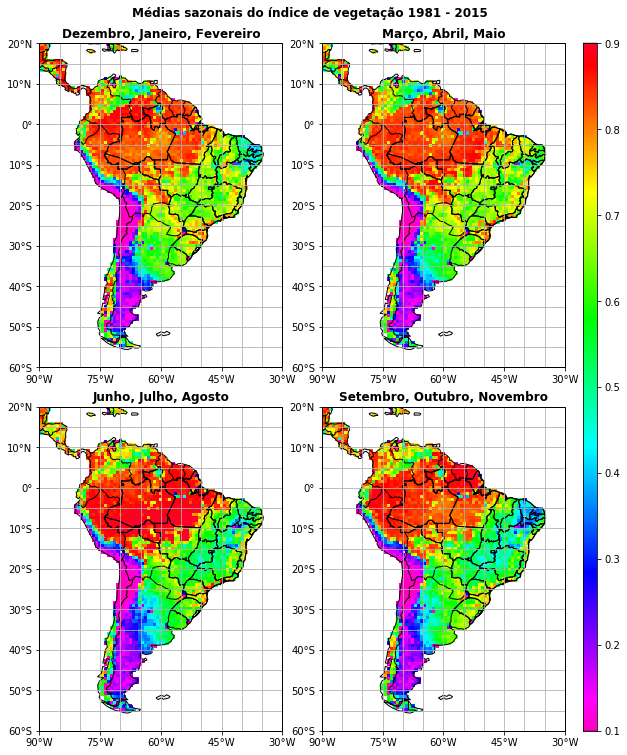

In [27]:
titles = ["Dezembro, Janeiro, Fevereiro", 
          "Março, Abril, Maio", 
          "Junho, Julho, Agosto", 
          "Setembro, Outubro, Novembro"]
seasons = ["DJF", "MAM", "JJA", "SON"]

# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(10, 12.5))
axgr = AxesGrid(fig=fig, 
                rect=111, 
                axes_class=axes_class,
                nrows_ncols=(2, 2),
                axes_pad=0.55,
                cbar_location="right",
                cbar_mode="single",
                cbar_pad=0.25,
                cbar_size="3%",
                label_mode="")

# Make maps.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([loni, lonf, latf, lati], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-90, -15, 15), crs=projection)
    axis.set_yticks(np.arange(-60, 30, 10), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-90, -25, 5), ylocs=range(-60, 25, 5))        
   
    # Plot data on these maps.
    p = DAr_se.sel(season=seasons[index]).plot(
        ax=axis,
        vmin=0.1,
        vmax=0.9,
        cmap=plt.cm.gist_rainbow_r,
        add_colorbar=False,
        add_labels=False)

    axis.set_title(titles[index], weight="bold")
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(geoms=[state], 
                            crs=projection, 
                            facecolor="none", 
                            edgecolor="black")    

# Fill common colorbar.        
cb = axgr.cbar_axes[0].colorbar(p)
cb.set_label_text("", weight="bold")
cb.cbar_axis.set_ticks(np.arange(0.1, 1.0, 0.1))        
plt.suptitle("Médias sazonais do índice de vegetação 1981 - 2015", weight="bold")
plt.subplots_adjust(top=0.99)    

# Save figures.
plt.savefig(fig_path + "ndvi_gimms_smeans_pt.jpg", dpi=200, bbox_inches="tight")

## Empirical orthogonal functions analysis for regridded data

In [28]:
# Preprocess regridded data at monthly time scale for EOF.
# First resample data at monthly scale. Then set as not a number the sea pixels.
DAr_mm_ts = DAr.resample({"time": "1MS"}).mean("time")
DAr_mm_ts = DAr_mm_ts.where(cond=DAr_mm_ts.mean("time") >= 0, other=np.nan)

In [29]:
# Create an EOF solver to do the EOF analysis.
solver = Eof(DAr_mm_ts)

In [30]:
# Retrieve EOFs, principal component time series, and fraction of explained variance as 
# xarray DataArary objects for all components.
EOFs = solver.eofs()
PCs = solver.pcs() 
PCTs = solver.varianceFraction()

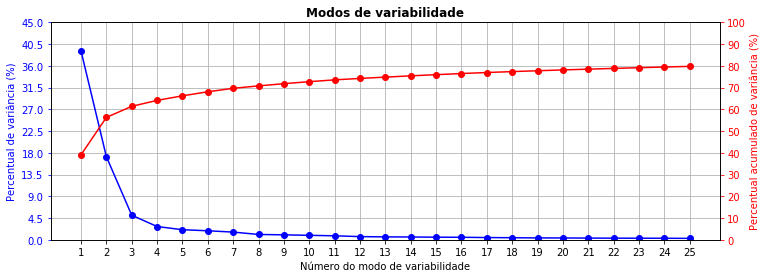

In [31]:
# Percentual of variance for N of the first modes.
N = 25
M = range(1, N + 1)
plt.figure(figsize=(12, 4))
plt.plot(M, PCTs.values[:N] * 100, "o-b")
plt.xlabel("Número do modo de variabilidade")
plt.ylabel("Percentual de variância (%)", color="blue")
plt.title("Modos de variabilidade", weight="bold")
plt.xticks(M)
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.set_ylim((0, 45))
ax2.set_ylim((0, 100))
ax2.plot(M, np.cumsum(PCTs.values[:N] * 100), "o-r")
ax2.set_ylabel("Percentual acumulado de variância (%)", color="red")
ax1.tick_params(axis="y", colors="blue")
ax2.tick_params(axis="y", colors="red")
ax1.set_yticks(np.linspace(0, ax1.get_yticks()[-1], 11))
ax2.set_yticks(np.linspace(0, ax2.get_yticks()[-1], len(ax1.get_yticks())))
ax1.grid();
plt.savefig(fig_path + "ndvi_gimms_modes_variances_pt.jpg", dpi=200, bbox_inches="tight")

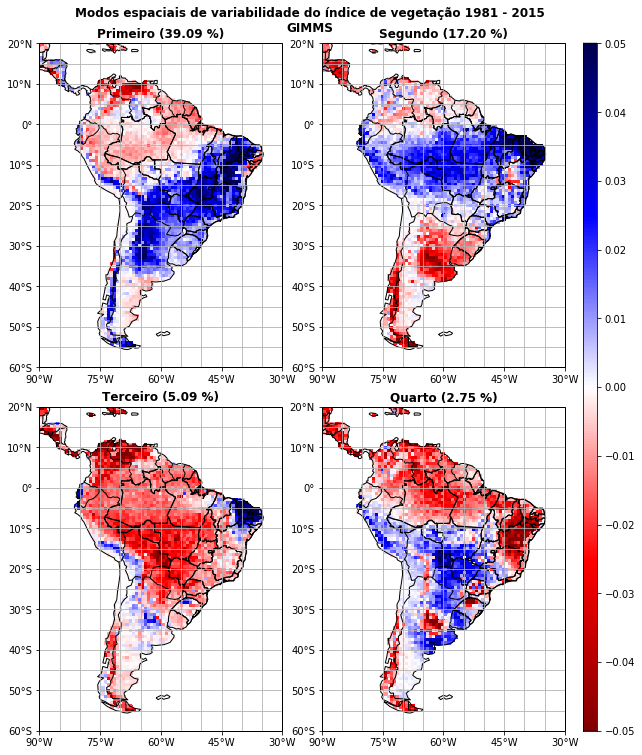

In [32]:
titles = ["Primeiro", "Segundo", "Terceiro", "Quarto"]

# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(10, 12.5))
axgr = AxesGrid(fig=fig, 
                rect=111, 
                axes_class=axes_class,
                nrows_ncols=(2, 2),
                axes_pad=0.55,
                cbar_location="right",
                cbar_mode="single",
                cbar_pad=0.25,
                cbar_size="3%",
                label_mode="")

# Make maps.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([loni, lonf, latf, lati], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-90, -15, 15), crs=projection)
    axis.set_yticks(np.arange(-60, 30, 10), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-90, -25, 5), ylocs=range(-60, 25, 5))        
   
    # Plot data on these maps.
    p = EOFs.sel(mode=index).where(DAr_mm.land_mask==True).plot(
        ax=axis,
        vmin=-0.05,
        vmax=0.05,
        cmap=plt.cm.seismic_r,
        add_colorbar=False,
        add_labels=False)

    axis.set_title(titles[index] + str(" (%.2f %%)" %(PCTs[index].values * 100)), 
                   weight="bold")
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(geoms=[state], 
                            crs=projection, 
                            facecolor="none", 
                            edgecolor="black")    

# Fill common colorbar.        
cb = axgr.cbar_axes[0].colorbar(p)
cb.set_label_text("", weight="bold")
cb.cbar_axis.set_ticks(np.arange(-0.05, 0.06, 0.01))        
plt.suptitle("Modos espaciais de variabilidade do índice de vegetação 1981 - 2015\n" + \
             "GIMMS", weight="bold")
plt.subplots_adjust(top=0.99)    

# Save figures.
plt.savefig(fig_path + "ndvi_gimms_modes_spatial_pt.jpg", dpi=200, bbox_inches="tight")

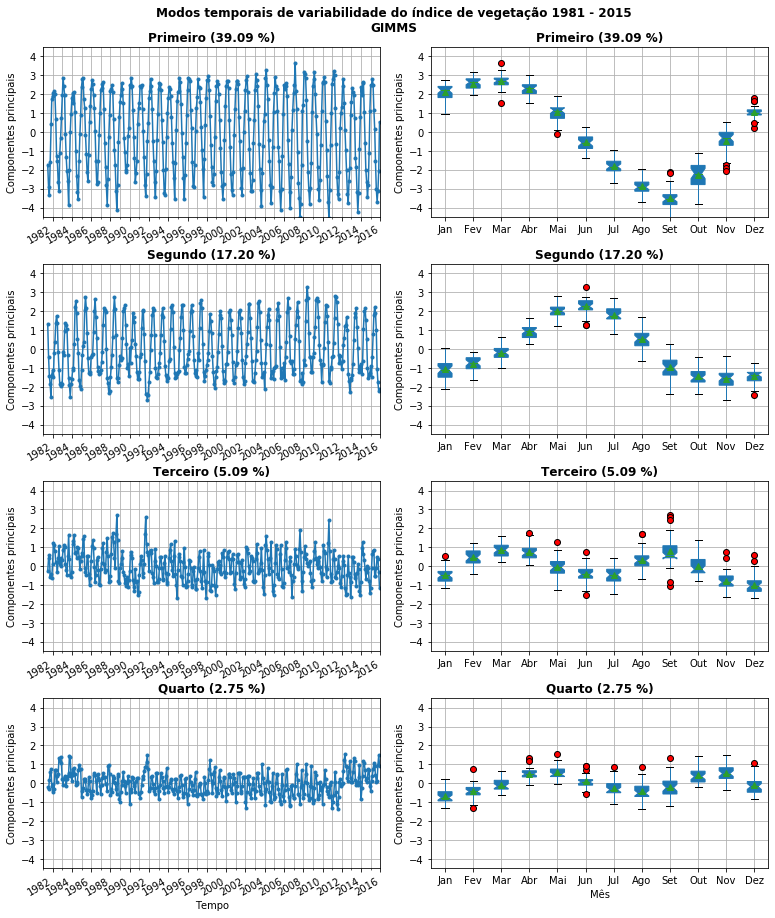

In [33]:
years = mdates.YearLocator(2)
years_fmt = mdates.DateFormatter("%Y")

titles = ["Primeiro", "Segundo", "Terceiro", "Quarto"]
modes = [0, 0, 1, 1, 2, 2, 3, 3]
fig, axes = plt.subplots(4, 2, figsize=(13, 14))
axes = axes.flatten()

for index, ax, mode in zip(range(len(axes)), axes, modes):
    
    # Left column,
    if index % 2 == 0:
        
        PCs.sel(mode=mode).plot(marker=".", ax=ax)
        ax.set_xlim(pd.Timestamp("1981"), pd.Timestamp("2016"))
        ax.set_xticks(pd.date_range(start="1981", end="2016", freq="1YS"), minor=True)
        ax.xaxis.set_major_locator(years)
        ax.xaxis.set_major_formatter(years_fmt)                             
        ax.grid(which="both")
        ax.set_title(titles[mode] + str(" (%.2f %%)" %(PCTs[mode].values * 100)), 
                     weight="bold")
        fig.suptitle("Modos temporais de variabilidade do índice de vegetação 1981 - 2015" \
                     "\nGIMMS", 
                     weight="bold")
        ax.set_xlabel("")
        ax.set_ylabel("Componentes principais")
        ax.set_ylim((-4.5, 4.5))
        ax.set_yticks(np.arange(-4, 5, 1))
    
    # Right hand side column.
    else:

        df = PCs.sel(mode=mode).to_dataframe()
        df = pd.pivot_table(df, index=df.index.year, columns=df.index.month, values="pcs") 
        df.columns = ["Jan", "Fev", "Mar", "Abr", "Mai", "Jun", 
                      "Jul", "Ago", "Set", "Out", "Nov", "Dez"]
        df.boxplot(ax=ax, patch_artist=True, showmeans=True, notch=True,
                   flierprops={"markerfacecolor": "red", "marker": "o"})
        ax.set_title(titles[mode] + str(" (%.2f %%)" %(PCTs[mode].values * 100)), 
                     weight="bold")
        ax.set_ylabel("Componentes principais")
        ax.set_ylim((-4.5, 4.5))
        ax.set_yticks(np.arange(-4, 5, 1))

axes[6].set_xlabel("Tempo")
axes[7].set_xlabel("Mês")
plt.subplots_adjust(top=0.94, wspace=0.15, hspace=0.275) 

# Save figures.
plt.savefig(fig_path + "ndvi_gimms_modes_temporal_pt.jpg", dpi=200, bbox_inches="tight")

In [34]:
# Reconstructed data for the first four modes.
rec = 4
F = solver.reconstructedField(rec) + DAr.mean("time").values

In [35]:
# Extract data as numpy array.
F_mm = F.groupby("time.month").mean("time")
DAr_rec = F_mm.values

# Original and reconstructed.
ORI = DAr_mm.values.reshape((-1, ))
REC = DAr_rec.reshape((-1, ))

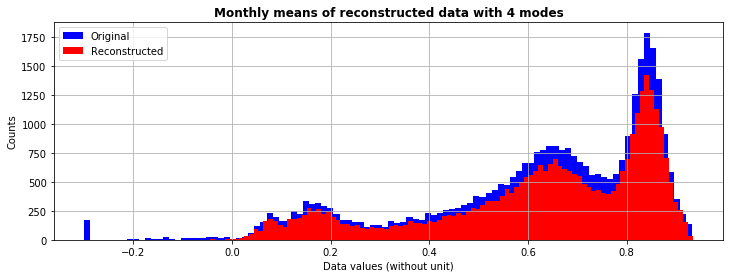

In [36]:
# Histogram of reconstructed monthly means.
plt.figure(figsize=(12, 4))
plt.hist(ORI, bins=100, color="blue", label="Original")
plt.hist(REC, bins=100, color="red", label="Reconstructed")
plt.title(f"Monthly means of reconstructed data with {rec} modes", weight="bold")
plt.xlabel("Data values (without unit)")
plt.ylabel("Counts")
plt.legend()
plt.grid();

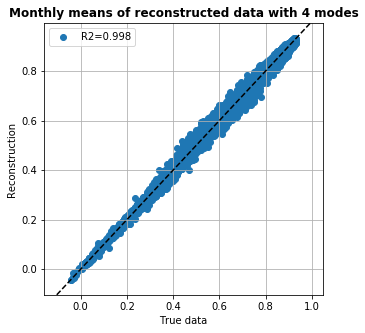

In [37]:
# Mask excluding np.nans for R2 calculation.
m1 = np.logical_not(np.isnan(ORI))
m2 = np.logical_not(np.isnan(REC))
mask = np.logical_and(m1, m2)

# Scatter plot of reconstruction.
plt.figure(figsize=(5, 5))
plt.scatter(ORI, REC, label=str("R2=%.3f" %r2_score(ORI[mask], REC[mask])))
plt.xlim()
p = plt.gca().get_xlim()
plt.plot(p, p, "k--")
plt.ylim(*p)
plt.title(f"Monthly means of reconstructed data with {rec} modes", weight="bold")
plt.xlabel("True data")
plt.ylabel("Reconstruction")
plt.legend()
plt.grid();